## ATIVIDADE 08 : PREDIÇÃO

### Objetivo
Realizar a previsão dos valores futuros da serie usando uma rede MLP e a predição UPA e MPA.


### METODOLOGIA
Nessa atividade , tentei encontrar a dimensão de inclusão e o atraso usando os metodos de cao e da informação mutua descrito nas notas de aula e artigos citados por ela fornecidas como base, um ponto importante é que no caso da serie de Henon , apos alguns testes optei por usar o atraso 1 .Apos esses valores serem estimados , apliquei a função reconst_v2_2010 (que foi convertida para python com base na fornecida em matlab) para encontrar as entradas da rede neural e por fim apliquei em um MLP de 1 camada oculta. Apos treinada os resultados foram reconhidos e exibidos para cada uma.Outro ponto importante é que a topologia da rede foi ajustada para cada serie

In [98]:
# Bibliotecas usadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

In [99]:
# Importa serie de Heron e  Mackey-Glass
Heron_dados = pd.read_csv(r"C:\Users\Família\Documents\CODIGOS DE ML\REDESM NEURAIS\Predição\henon_200_dados.dat",header=None)
Heron = np.array(Heron_dados)#converter em array 
Mackey_Glass_dados= pd.read_csv(r"C:\Users\Família\Documents\CODIGOS DE ML\REDESM NEURAIS\Predição\mackeyglass_dou_4.dat",header=None)
Mackey_Glass =np.array(Mackey_Glass_dados)#converter em array 

In [100]:
#Normalizar dados da serie
#Heron
Heron_max = Heron.max(axis=0)
Heron_min = Heron.min(axis=0)
Heron_normalizada = 2*((Heron-Heron_min)/(Heron_max-Heron_min))-1

#Mackey_Glass
Mackey_Glass_max = Mackey_Glass.max(axis=0)
Mackey_Glass_min = Mackey_Glass.min(axis=0)
Mackey_Glass_normalizada = 2*((Mackey_Glass-Mackey_Glass_min)/(Mackey_Glass_max - Mackey_Glass_min))-1

In [101]:



def calcular_informacao_mutua(x, max_lag=100, n_bins=32, epsilon=1e-12):
    x = np.asarray(x)
    bins = np.linspace(-1 - epsilon, 1 + epsilon, n_bins + 1)
    informacao_mutua = []

    for tau in range(0, max_lag + 1):
        if tau == 0:
            x1 = x
            x2 = x
        else:
            x1 = x[:-tau]
            x2 = x[tau:]

        # Histograma conjunto
        counts, _, _ = np.histogram2d(x1, x2, bins=[bins, bins], density=False)
        counts += epsilon  # evitar log(0)
        pxy = counts / np.sum(counts)

        px = pxy.sum(axis=1)

       
        termo_conjunto = np.sum(pxy * np.log(pxy))
        termo_marginal = np.sum(px * np.log(px))
        im = termo_conjunto - 2 * termo_marginal

        informacao_mutua.append(im)

    return np.arange(0, max_lag + 1), np.array(informacao_mutua)
    
def plotar_info_mutua(lags, im, titulo="Informação Mútua vs Atraso"):
    plt.figure(figsize=(10,5))
    plt.plot(lags, im, marker='o')
    plt.title(titulo)
    plt.xlabel("Atraso (τ)")
    plt.ylabel("Informação Mútua I(τ)")
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(0, 10)
    plt.show()

def reconstruir_vetores(x, d, tau):
    N = len(x)
    T = N - (d - 1) * tau
    return np.array([x[i:i + d * tau:tau] for i in range(T)])

def encontrar_vizinho_mais_proximo(vetores):
    n = vetores.shape[0]
    vizinhos = []
    for i in range(n):
        dist = np.max(np.abs(vetores[i] - vetores), axis=1)
        dist[i] = np.inf  
        vizinhos.append(np.argmin(dist))
    return np.array(vizinhos)

def calcular_E1(x, max_d=15, tau=1):
    x = np.asarray(x)
    E = []

    for d in range(1, max_d + 2): 
        Y_d  = reconstruir_vetores(x, d, tau)
        Y_d1 = reconstruir_vetores(x, d + 1, tau)
        Y_d = Y_d[:len(Y_d1)]
        indices = encontrar_vizinho_mais_proximo(Y_d)

        # Calcular a(t,d) para cada t
        a_t = []
        for i in range(len(Y_d1)):
            j = indices[i]
            if j >= len(Y_d1):  
                continue
            num = np.max(np.abs(Y_d1[i] - Y_d1[j]))
            den = np.max(np.abs(Y_d[i] - Y_d[j]))
            if den == 0:
                continue
            a_t.append(num / den)

        E.append(np.mean(a_t))

    # Cálculo de E1(d) = E(d+1)/E(d)
    E1 = [E[i+1] / E[i] for i in range(len(E) - 1)]
    return np.arange(1, max_d + 1), np.array(E1)

def plotar_E1(dimensoes, E1):
    plt.figure(figsize=(10,5))
    plt.plot(dimensoes, E1, marker='o')
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.title("Curva E1(d) — Método de Cao")
    plt.xlabel("Dimensão de imersão d")
    plt.ylabel("E1(d)")
    plt.grid(True)
    plt.xlim(left=1)
    plt.ylim(bottom=0)
    plt.show()

def reconst_narx(xx, dimensao, atraso, ordem):
    N = len(xx)
    con = []
    serie = xx.copy()
    for exemplos in range(N - (dimensao - 1) * atraso - 1):
        start_idx = exemplos
        end_idx = start_idx + ordem
        if start_idx - ordem + 1 < 0:
            pad = ordem - (start_idx + 1)
            padded = np.concatenate((np.zeros(pad), serie[:start_idx+1]))
            con.append(padded)
        else:
            con.append(serie[start_idx - ordem + 1: start_idx + 1])
    return np.array(con).T 

def reconst_v2_2010(xx, dimensao, atraso, ordem, hold_out):
    serie = np.array(xx).flatten()  # garantir vetor 1D
    N = len(serie)

    P = []
    P_kpa = None
    for exemplos in range(N - (dimensao - 1) * atraso):
        indices = exemplos + np.arange(0, dimensao) * atraso
        vet = serie[indices]
        P.append(vet)

        if exemplos == N - (dimensao - 1) * atraso - hold_out - 1:
            P_kpa = serie[exemplos : exemplos + (dimensao - 1) * atraso + 1]

    P = np.array(P)
    P = P[:-1, :] 
    contexto = reconst_narx(xx, dimensao, atraso, ordem)

    T = []
    for exemplos in range(len(P)):
        idx = exemplos + 1 + (dimensao - 1) * atraso
        T.append(serie[idx])
    T = np.array(T)

    # Divisão treino / teste
    Ptreino = P[: -hold_out, :]
    Ttreino = T[: -hold_out]

    Pteste = P[-hold_out :, :]
    Tteste = T[-hold_out :]

    return P, T, Ptreino, Pteste, Ttreino, Tteste, contexto, P_kpa



    
#Função de ativação
def tanh(x):
    return np.tanh(x)

def tanh_derivada(x):
    return 1 - np.tanh(x)**2
    
def linear(x):
    return x
    
def calcular_nmse(y_pred, y_true):
    y_pred = np.ravel(y_pred)
    y_true = np.ravel(y_true)
    mse = np.mean((y_pred - y_true) ** 2)
    var = np.var(y_true)
    return mse / (var + 1e-10)

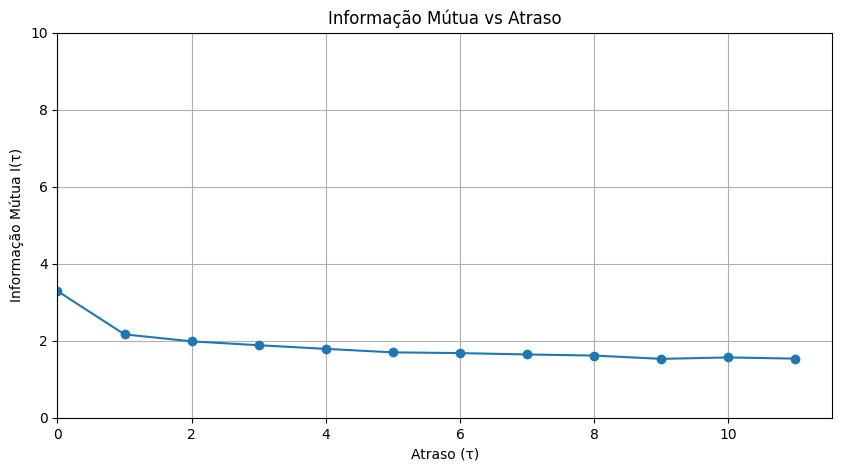

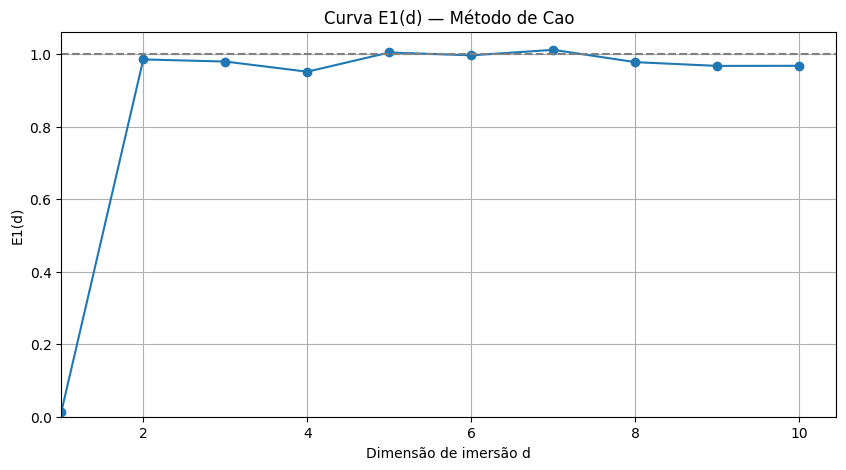

neuronios da camada oculta = 4


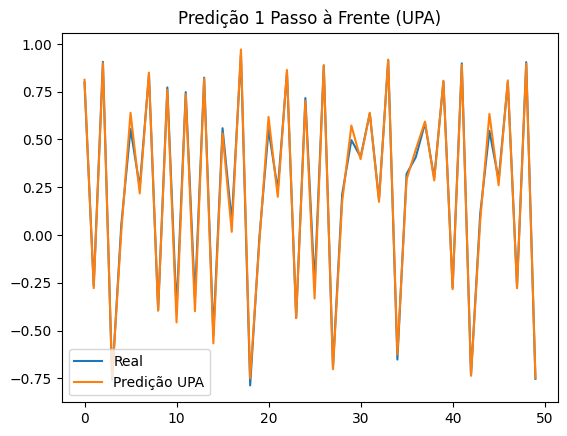

Média do NMSE - UPA (1 passo à frente): 0.002799


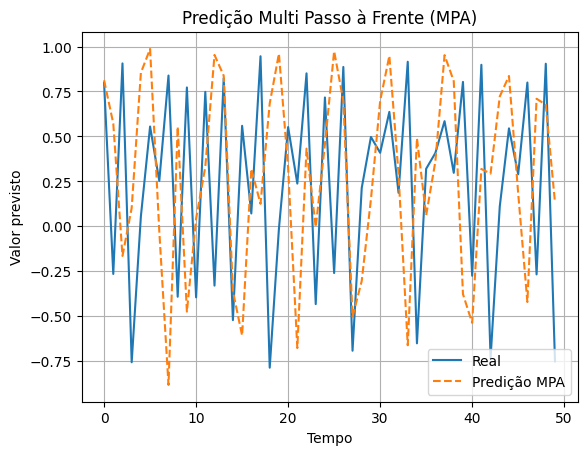

Média do NMSE - MPA (multi passo à frente): 2.060210


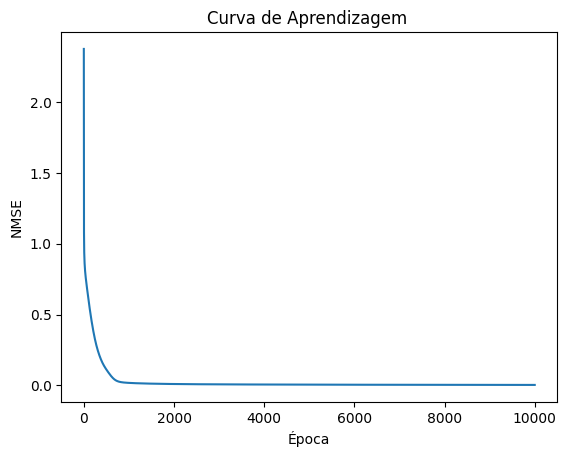

In [102]:
  
serie1D = Heron_normalizada.ravel()#garanti shape fique (x,)
lags, im = calcular_informacao_mutua(serie1D, max_lag=11)
# Plotar
plotar_info_mutua(lags, im)
# Calcular E1(d) 
d_vals, E1_vals = calcular_E1(serie1D, max_d=10, tau=1) 

# Plotar
plotar_E1(d_vals, E1_vals)

P, T, Ptreino, Pteste, Ttreino, Tteste, contexto, P_kpa = reconst_v2_2010(serie1D, 2, 1, 5, 50)
N ,p = P.shape

T_aj=T.copy().reshape(-1, 1)
M = T_aj.shape[1]
epslon = 0.1
neuronios_camada_1 = int(np.floor(((epslon * N) - M) / (M + p + 1)))
print("neuronios da camada oculta = %d" %neuronios_camada_1)     

total_de_teste = 10
matrizes_ts = []
acuracia_epoca_treino=[]
acuracia_epoca_teste=[]
nmse_upa_lista = []
nmse_mpa_lista = []
curvas_erro = []
neuronios_camada_1= 4
taxa_de_aprendizagem = 0.001
epocas_maximas = 10000
for i in range(total_de_teste):
    np.random.seed(i+1) #
    # Dados de treino
    X_treino = Ptreino
    X_teste =  Pteste 
    Y_treino = Ttreino.reshape(-1, 1)
    Y_teste = Tteste.reshape(-1, 1)
    
    #Entradas e saídas
    entradas = X_treino 
    saidas = Y_treino.copy()
    linhas_entradas,colunas_entradas = entradas.shape
    linhas_saidas,colunas_saidas = saidas.shape
    #Iniciar pesos
    pre_bias = np.ones(linhas_entradas)*(-1)
    pre_bias = pre_bias.reshape(linhas_entradas,1)

    entradas_bias = np.concatenate((pre_bias,entradas),axis=1)
    entradas_bias_linhas,entradas_bias_colunas = entradas_bias.shape 
    pesos_camada_1 = (np.random.randn(neuronios_camada_1,entradas_bias_colunas))*np.sqrt(2 / (neuronios_camada_1+entradas_bias_colunas))
    pesos_camada_2 = (np.random.randn(colunas_saidas,neuronios_camada_1+1))*np.sqrt(2 / (colunas_saidas+(neuronios_camada_1+1)))
   
    epocas = 0 #iniciar epocas   
    erro_medio = []
    for epocas in range(epocas_maximas):
        # Forward pass
        saida_camada_1 = tanh(pesos_camada_1 @ entradas_bias.T) 

        # Adicionar os bias da camada 2(saida)
        pre_bias_camada_1 = np.ones(saida_camada_1.shape[1])*(-1)
        pre_bias_camada_1 = pre_bias_camada_1.reshape(1,saida_camada_1.shape[1])
        saida_camada_1_bias = np.concatenate((pre_bias_camada_1,saida_camada_1),axis=0)
        saida_camada_2 =linear(pesos_camada_2 @ saida_camada_1_bias) 
    
        # Calcular erro
        erro = saida_camada_2- saidas.T
        erro_medio_epoca = calcular_nmse(saida_camada_2, saidas.T)
        erro_medio.append(erro_medio_epoca)
    
        #Começando com o calculo do delta da camada 2
        delta_camada_2 = erro
        pesos_camada_2 = pesos_camada_2 -  taxa_de_aprendizagem*delta_camada_2 @ saida_camada_1_bias.T
 
        pesos_camada_2_sem_bias = pesos_camada_2[:, 1:] # bias n participa da retropropagação
        delta_camada_1 =(pesos_camada_2_sem_bias.T @ delta_camada_2 )*tanh_derivada(pesos_camada_1 @ entradas_bias.T)
        pesos_camada_1 = pesos_camada_1 -  taxa_de_aprendizagem*delta_camada_1 @ entradas_bias
    curvas_erro.append(erro_medio)
    #Fim do treinamento       
    def forward(X_bias, pesos_camada_1, pesos_camada_2):
        z1 = pesos_camada_1 @ X_bias.T
        a1 = np.tanh(z1)
        a1b = np.vstack([[-1]*a1.shape[1], a1])
        z2 = pesos_camada_2 @ a1b
        y_hat = z2  
        return y_hat.T  

    # Preparar dados de teste para o forward:
    pre_bias_ts = np.ones(Pteste.shape[0]) * -1
    X_ts_bias = np.concatenate((pre_bias_ts.reshape(-1,1), Pteste), axis=1)

    # Fazer predição 1 passo à frente:
    y_pred_upa = forward(X_ts_bias, pesos_camada_1, pesos_camada_2)
         
    pre_bias_ts = np.ones(X_teste.shape[0]) * -1
    X_ts_bias   = np.concatenate((pre_bias_ts.reshape(-1,1), X_teste), axis=1)
    y_pred_upa = forward(X_ts_bias, pesos_camada_1, pesos_camada_2)
    nmse_upa =  calcular_nmse(y_pred_upa.flatten(), Tteste.flatten())
    nmse_upa_lista.append(nmse_upa)

    entrada_atual = Pteste[0].copy()  
    predicoes_mpa = []

    for i in range(len(Tteste)):
        entrada_bias = np.concatenate(([-1], entrada_atual)).reshape(1, -1)
        y_pred_mpa = forward(entrada_bias, pesos_camada_1, pesos_camada_2)[0, 0]
        predicoes_mpa.append(y_pred_mpa)
    
        entrada_atual = np.roll(entrada_atual, 1)
        entrada_atual[0] = y_pred_mpa  # usa a saída anterior como entrada


    predicoes_mpa = np.array(predicoes_mpa)
    nmse_mpa = calcular_nmse(predicoes_mpa.flatten(), Tteste.flatten())
    nmse_mpa_lista.append(nmse_mpa)

# Plotar a predição UPA para visualização e media das 10 rodadas
plt.plot(Tteste, label='Real')
plt.plot(y_pred_upa, label='Predição UPA')
plt.legend()
plt.title('Predição 1 Passo à Frente (UPA)')
plt.show()
media_nmse_upa = np.mean(nmse_upa_lista)


print(f"Média do NMSE - UPA (1 passo à frente): {media_nmse_upa:.6f}")

# Plotar a predição MPA para visualização e media das 10 rodadas
plt.plot(Tteste, label='Real')
plt.plot(predicoes_mpa, label='Predição MPA', linestyle='--')
plt.title('Predição Multi Passo à Frente (MPA)')
plt.xlabel('Tempo')
plt.ylabel('Valor previsto')
plt.legend()
plt.grid(True)
plt.show()
media_nmse_mpa = np.mean(nmse_mpa_lista)
print(f"Média do NMSE - MPA (multi passo à frente): {media_nmse_mpa:.6f}")

#Erro medio por epoca
curvas_erro_array = np.array(curvas_erro) 
curva_media = np.mean(curvas_erro_array, axis=0)
plt.plot(curva_media)
plt.title('Curva de Aprendizagem ')
plt.xlabel('Época')
plt.ylabel('NMSE')
plt.show()



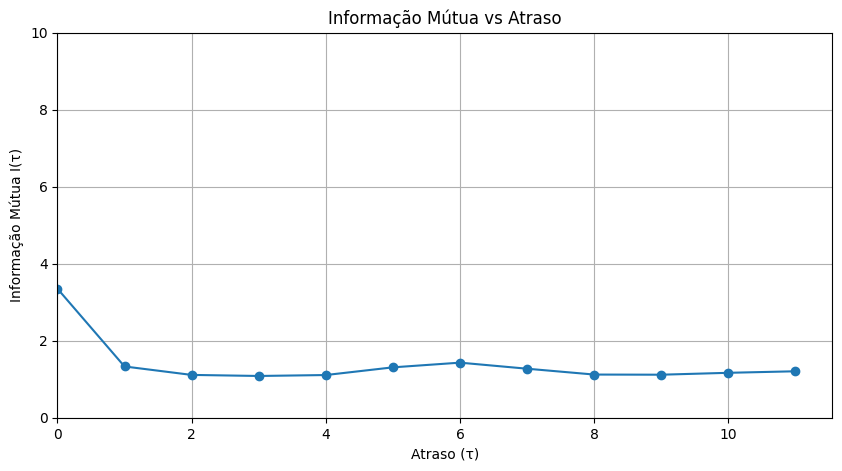

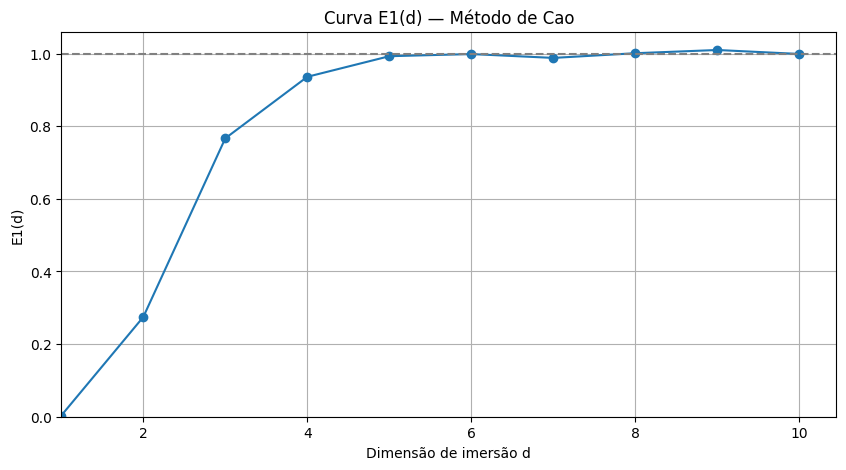

neuronios da camada oculta = 6


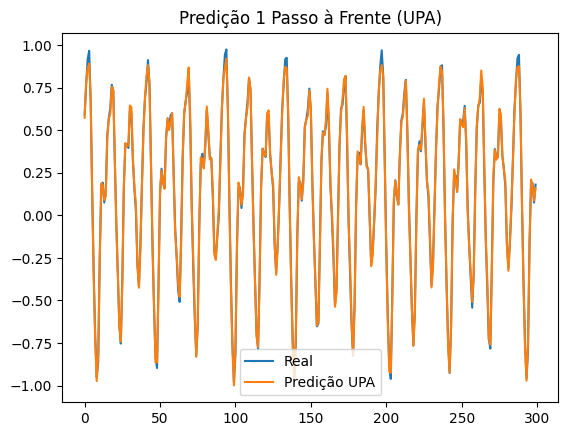

Média do NMSE - UPA (1 passo à frente): 0.002195


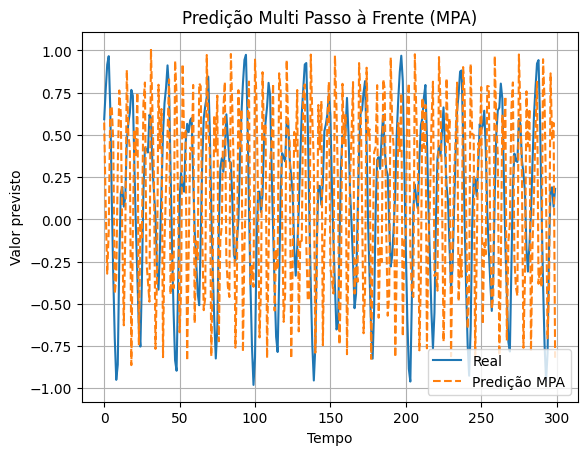

Média do NMSE - MPA (multi passo à frente): 2.241678


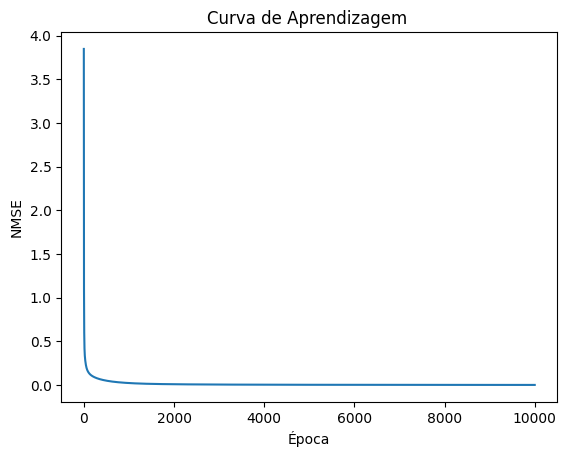

In [103]:
  
serie1D = Mackey_Glass_normalizada.ravel()#garanti shape fique (x,)
lags, im = calcular_informacao_mutua(serie1D, max_lag=11)
# Plotar
plotar_info_mutua(lags, im)
# Calcular E1(d) 
d_vals, E1_vals = calcular_E1(serie1D, max_d=10, tau=2) 

# Plotar
plotar_E1(d_vals, E1_vals)#

P, T, Ptreino, Pteste, Ttreino, Tteste, contexto, P_kpa = reconst_v2_2010(serie1D, 5, 2, 5, 300)
N ,p = P.shape

T_aj=T.copy().reshape(-1, 1)
M = T_aj.shape[1]
epslon = 0.1
neuronios_camada_1 = int(np.floor(((epslon * N) - M) / (M + p + 1)))
print("neuronios da camada oculta = %d" %neuronios_camada_1)     

total_de_teste = 10
matrizes_ts = []
acuracia_epoca_treino=[]
acuracia_epoca_teste=[]
nmse_upa_lista = []
nmse_mpa_lista = []
curvas_erro = []
neuronios_camada_1= 6
taxa_de_aprendizagem = 0.0008
epocas_maximas = 10000
for i in range(total_de_teste):
    np.random.seed(i+1) 
    # Dados de treino
    X_treino = Ptreino
    X_teste =  Pteste 
    Y_treino = Ttreino.reshape(-1, 1)
    Y_teste = Tteste.reshape(-1, 1)
    
    #Entradas e saídas
    entradas = X_treino 
    saidas = Y_treino.copy()
    linhas_entradas,colunas_entradas = entradas.shape
    linhas_saidas,colunas_saidas = saidas.shape
    #Iniciar pesos
    pre_bias = np.ones(linhas_entradas)*(-1)
    pre_bias = pre_bias.reshape(linhas_entradas,1)

    entradas_bias = np.concatenate((pre_bias,entradas),axis=1)
    entradas_bias_linhas,entradas_bias_colunas = entradas_bias.shape 
    pesos_camada_1 = (np.random.randn(neuronios_camada_1,entradas_bias_colunas))*np.sqrt(2 / (neuronios_camada_1+entradas_bias_colunas))
    pesos_camada_2 = (np.random.randn(colunas_saidas,neuronios_camada_1+1))*np.sqrt(2 / (colunas_saidas+(neuronios_camada_1+1)))
   
    epocas = 0 #iniciar epocas   
    erro_medio = []
    for epocas in range(epocas_maximas):
        # Forward pass
        saida_camada_1 = tanh(pesos_camada_1 @ entradas_bias.T) 

        # Adicionar os bias da camada 2(saida)
        pre_bias_camada_1 = np.ones(saida_camada_1.shape[1])*(-1)
        pre_bias_camada_1 = pre_bias_camada_1.reshape(1,saida_camada_1.shape[1])
        saida_camada_1_bias = np.concatenate((pre_bias_camada_1,saida_camada_1),axis=0)
        saida_camada_2 =linear(pesos_camada_2 @ saida_camada_1_bias) 
    
        # Calcular erro
        erro = saida_camada_2- saidas.T
        erro_medio_epoca = calcular_nmse(saida_camada_2, saidas.T)
        erro_medio.append(erro_medio_epoca)
    
        #Começando com o calculo do delta da camada 2
        delta_camada_2 = erro
        pesos_camada_2 = pesos_camada_2 -  taxa_de_aprendizagem*delta_camada_2 @ saida_camada_1_bias.T
 
        pesos_camada_2_sem_bias = pesos_camada_2[:, 1:] # bias n participa da retropropagação
        delta_camada_1 =(pesos_camada_2_sem_bias.T @ delta_camada_2 )*tanh_derivada(pesos_camada_1 @ entradas_bias.T)
        pesos_camada_1 = pesos_camada_1 -  taxa_de_aprendizagem*delta_camada_1 @ entradas_bias
    curvas_erro.append(erro_medio)
    #Fim do treinamento       
    def forward(X_bias, pesos_camada_1, pesos_camada_2):
        z1 = pesos_camada_1 @ X_bias.T
        a1 = np.tanh(z1)
        a1b = np.vstack([[-1]*a1.shape[1], a1])
        z2 = pesos_camada_2 @ a1b
        y_hat = z2  
        return y_hat.T  

    # Preparar dados de teste para o forward:
    pre_bias_ts = np.ones(Pteste.shape[0]) * -1
    X_ts_bias = np.concatenate((pre_bias_ts.reshape(-1,1), Pteste), axis=1)

    # Fazer predição 1 passo à frente:
    y_pred_upa = forward(X_ts_bias, pesos_camada_1, pesos_camada_2)
         
    pre_bias_ts = np.ones(X_teste.shape[0]) * -1
    X_ts_bias   = np.concatenate((pre_bias_ts.reshape(-1,1), X_teste), axis=1)
    y_pred_upa = forward(X_ts_bias, pesos_camada_1, pesos_camada_2)
    nmse_upa =  calcular_nmse(y_pred_upa.flatten(), Tteste.flatten())
    nmse_upa_lista.append(nmse_upa)

    entrada_atual = Pteste[0].copy()  
    predicoes_mpa = []

    for i in range(len(Tteste)):
        entrada_bias = np.concatenate(([-1], entrada_atual)).reshape(1, -1)
        y_pred_mpa = forward(entrada_bias, pesos_camada_1, pesos_camada_2)[0, 0]
        predicoes_mpa.append(y_pred_mpa)
    
        entrada_atual = np.roll(entrada_atual, 1)
        entrada_atual[0] = y_pred_mpa  # usa a saída anterior como entrada


    predicoes_mpa = np.array(predicoes_mpa)
    nmse_mpa = calcular_nmse(predicoes_mpa.flatten(), Tteste.flatten())
    nmse_mpa_lista.append(nmse_mpa)

# Plotar a predição UPA para visualização e media das 10 rodadas
plt.plot(Tteste, label='Real')
plt.plot(y_pred_upa, label='Predição UPA')
plt.legend()
plt.title('Predição 1 Passo à Frente (UPA)')
plt.show()
media_nmse_upa = np.mean(nmse_upa_lista)


print(f"Média do NMSE - UPA (1 passo à frente): {media_nmse_upa:.6f}")

# Plotar a predição MPA para visualização e media das 10 rodadas
plt.plot(Tteste, label='Real')
plt.plot(predicoes_mpa, label='Predição MPA', linestyle='--')
plt.title('Predição Multi Passo à Frente (MPA)')
plt.xlabel('Tempo')
plt.ylabel('Valor previsto')
plt.legend()
plt.grid(True)
plt.show()
media_nmse_mpa = np.mean(nmse_mpa_lista)
print(f"Média do NMSE - MPA (multi passo à frente): {media_nmse_mpa:.6f}")

#Erro medio por epoca
curvas_erro_array = np.array(curvas_erro) 
curva_media = np.mean(curvas_erro_array, axis=0)
plt.plot(curva_media)
plt.title('Curva de Aprendizagem ')
plt.xlabel('Época')
plt.ylabel('NMSE')
plt.show()

